# VI. Deployment del modelo de predicción de ventas en Flask y Docker

Una vez generado el mejor algoritmo predictivo, este se implementó en una aplicación en Python para permitir que la empresa 1C pueda hacer predicciones del nivel de ventas mensuales por producto y tienda. Esta aplicación está construida para que pueda descargarse a cualquier computadora y operarse como un webservice que está disponible en la red para recibir los inputs del modelo y devolver la predicción de las ventas.

En este caso el input del modelo corresponde al código del producto y tienda de interés, los cuáles deben ser introducidos a la aplicación de una manera específica que se detalla en este documento.

La predicción del modelo corresponde al nivel de ventas del mes de noviembre de 2015. Se eligió esta fecha para poder ser consistentes con los resultados de la evaluación del modelo en la plataforma de Kaggle. Sin embargo, puede ser extendido hacia otros meses adelante.


<img src="img/deployment.png">

## Herramientas

**Flask.** LLa aplicación se escribió en Flask el microframework de Python. Se utilizó esta herramienta porque es fácil crear aplicaciones con muy pocas líneas de código. Asimismo, es muy útil para poner en funcionamiento las aplicaciones en poco tiempo. Asimismo, para simplificar su integración con Python, las librerías Sklearn y xgboost para machine learning.

**Pickle.** El mejor algoritmo para predecir el nivel de ventas con sus parámetros ajustados se guardó para poder ser utilizado en cualquier momento sin necesidad de tener que entrenarlo nuevamente. El formato que se eligió para guardarlo es Pickle, está librería se ejecuta un algoritmo para serializar y de-serializar la estructura de un objeto en Python. En este caso serializar significa convertir el archivo en una cadena de caracteres, en este caso bytes, antes de escribirlo en un archivo. Dicha cadena de caracteres tiene toda la información necesaria para volver a construir el objeto en Python en otro script. En este caso el modelo entrenado se serializa para ser transportado a diferentes máquinas a través de la aplicación. Una vez que se ejecuta la aplicación el modelo se de-serializa quedando en el estado en el que se dejo después de entrenar, y así poder ser utilizado inmediatamente para hacer predicciones.

**Docker.**  Es una herramienta open source diseñada para hacer más fácil la creación, implementación y ejecución de aplicaciones utilizando contenedores. Los contenedores incluyen todas las librerías y otras dependencias necesarias para ejecutar la aplicación. Por ejemplo: una distribución Linux, una distribución de python 3, las librerías para ejecutar la predicción del un algoritmo de machine learning. Como todo esto va dentro del mismo contenedor, se puede asegurar que la aplicación correrá en cualquier computadora Linux. Sin serlo funciona como una máquina virtual. La diferencia es que no crea un sistema operativo virtual. Lo que hace es permitir que las aplicaciones utilicen el mismo kernel de linux que el sistema que está utilizando y solo distribuye aplicaciones que no este corriendo la máquina local. Esto reduce el tamaño de la aplicación y maximiza el desempeño.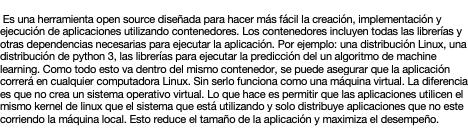

<img src="img/herramientas.png">

## Procedimiento

En la sección de evaluación el mejor modelo fue un modelo xgBoost. El modelo entrenado fue serializado con pickle y guardado en el archivo *modelo_xgboost.pkl* dentro del directorio Flask. A continuación, se presentan los pasos que se siguieron para crear la aplicación y distribuirla en un contenedor de Docker:

**Paso 1:** En el directorio Flask se creó un Python script llamado *app.py* en el que se programó una aplicación cuya función es de-serializar el archivo *modelo_xgboost.pkl* que contiene el algoritmo predictivo. Después la aplicación se pone a escuchar en la red solicitudes de usuarios que envían información sobre un producto y tienda de la compañía 1C. Cuando recibe una de estas solicitudes, la aplicación utiliza el modelo xgboost entrenado previamente para predecir y devolver al usuario el nivel de ventas respectivo para el mes de noviembre. La aplicación funciona como un web service a través de la terminal.

A continuación, se muestra el script del archivo **app.py**:

In [ ]:
######################### app.py ################################

# Importar las siguientes librerías
from flask import Flask, url_for, jsonify, request, json
import pickle
import numpy as np

# Abrir y deserializar el modelo de machine learning guardado en el archivo modelo_xgboost.pkl. 
with open("modelo_xgboost.pkl", "rb") as f:
        model = pickle.load(f)

# Aplicación de flask.
app = Flask(__name__)
@app.route('/', methods=['POST']) 
# Función que se ejecuta cada vez que se envía una solicitud de predicción.
def predict(): 
    if request.headers['Content-Type'] == 'application/json':
        input=request.json['input']
    results = {} 
    y_hat = model.predict(np.array(input))
    results['parameters']= input
    results['resultado'] = y_hat.tolist() 
    return jsonify(results)

if __name__ == '__main__':
    # Ejecutar la aplicación en el docker en el puerto 80.
    app.run(host='0.0.0.0', port=80)

**Paso 2:** Crear un script con las instrucciones para construir una imagen en Docker con todas las librerías y dependencias necesarias para ejecutar el programa app.py. Este script se guarda en el directorio Flask con el nombre *Dockerfile*. 

In [ ]:
####################### Docker file #######################

# Utilizar una imagen de Docker con una distribución oficial de Python
FROM python:3.6.8

# Fijar el directorio de trabajo en el directorio /app
WORKDIR /app

# Copiar el contenido del directorio actual dentro del contenedor en el directorio /app
COPY . /app

# Instalar todos los paquetes especificados en la lista requirements.txt
RUN pip install --trusted-host pypi.python.org -r requirements.txt

# Abrir el puerto 80 al resto del mundo fuera de este contenedor
EXPOSE 80

# Eejecutar app.py cuando se lance el contenedor
CMD ["python","app.py"]

Los paquetes indicados en el archivo de requirements.txt son aquellos que se necesitan instalar en el contenedor para que el modelo predictivo pueda funcionar.

In [ ]:
####################### requirements.txt ######################
Flask
numpy
pandas
scipy
sklearn
xgboost
jsonify
request

Hasta el momento lo único que hemos hecho fue crear el *directorio Flask* con los siguientes archivos:

* app.py
* Dockerfile
* requirements.txt

<img src="img/flask_directory.png">

**Paso 3:** Abrir una terminal en la computadora para crear una imagen en Docker llamada *salespredictor* utilizando el Dockerfile que se creó en el paso 2. Fijar el directorio en la **carpeta Flask**, e introducir el siguiente código **en la terminal**.

In [ ]:
###################### TERMINAL #########################

# En la terminal crear una imagen llamada salespredictor. 
# El "." indica que el Dockerfile se encuentra en este directorio
docker build --tag=salespredictor .

**Paso 4:** Creamos una instancia de la imagen salespredictor y lo mapeamos en el puerto 4000 de la máquina local al puerto 80 que utiliza el contenedor de Docker.

In [ ]:
###################### TERMINAL #########################

# Ejecutar el app en el background con -d, mapeamos el puerto 4000 de la máquina local al
# puerto 80 el contenedor utilizando -p:
docker run -p 4000:80 salespredictor

El contenedor ejecuta nuestra aplicación y se encuentra escuchando solicitudes para predecir el nivel de ventas.

<img src="img/server.png">

**Paso 5:** Checamos que la aplicación este funcionando enviando una solicitud para predecir ventas. Para lo cual abrir una nueva terminal y enviar al web service los siguientes inputs del modelo.

In [ ]:
#################### NUEVA TERMINAL ######################

# Enviamos la predicción al docker para verificar que funciona
curl -H "Content-type: application/json" -X POST http://localhost:4000/ -d '{"input":[[
    5.00000000e+00, 
    5.03700000e+03, 
    3.40000000e+01, 
    1.90000000e+01,
    1.49900000e+03, 
    2.50000000e+01, 
    1.00000000e+00, 
    1.03072193e+03,
    1.05200000e+03,
    1.09015544e+00,
    1.68147788e+03,
    2.44300000e+03,
    1.04179104e+00,
    0.00000000e+00,
    9.41385173e+02,
    1.10000000e+02,
    1.42857143e+00,
    1.03478434e+03,
    1.09200000e+03,
    1.14826498e+00,
    1.35881086e+03,
    3.97900000e+03,
    1.27368758e+00,
    1.00000000e+00,
    8.94589833e+02,
    1.19000000e+02,
    1.19000000e+00,
    9.21702970e+02,
    1.29400000e+03,
    1.08013356e+00,
    1.14089467e+03,
    4.66700000e+03,
    1.12620656e+00,
    3.00000000e+00,
    1.54286875e+03,
    8.70000000e+01,
    1.08750000e+00,
    9.58609887e+02,
    1.01200000e+03,
    1.14350282e+00,
    1.41918314e+03,
    3.39200000e+03,
    1.06199123e+00,
    1.00000000e+00]]}'

Vemos que el web service responde a nuestra solicitud regresando los resultados de la predicción del nivel de ventas para el mes de noviembre de 2015. Hemos comprobado que la aplicación funciona bien.

**Paso 6:** El siguiente paso es subir nuestra imagen de la aplicación salespredictor a la nube. Dado que estamos trabajando en docker la nube es [Docker Hub](https://hub.docker.com/), para lo cual es necesario contar con una cuenta. Es preciso mencionar que la cuentas pública por lo que la imagen estará disponible para cualquiera que la quiera utilizar.

El primer paso para subir a la nueva nuestra imagen es hacer un login a la plataforma utilizando nuestro usuario y contraseña.

In [ ]:
############################## TERMINAL #########################

# Login al Docker public registry
docker login

Ahora identificamos la imagen que queremos subir indicando el nombre de usuario, el repositorio y el identificador de la versión.

In [ ]:
############################## TERMINAL #########################

# Taggeamos la imagen con el nombre de usuario, el nombre del repositorio y el tag
docker tag salespredictor danteruiz/salespredictor:latest

Empujamos a la nube la imagen.

In [ ]:
############################## TERMINAL #########################

# Publicar la imagen en docker
docker push danteruiz/salespredictor:latest

Ahora la imagen vive en la nube y puede ser descargada a cualquier computadora utilizando el siguiente comando desde la terminal.

In [ ]:
############################## TERMINAL #########################

docker pull danteruiz/salespredictor

<img src="img/dockerhub.png">

Finalmente, para correr el contenedor descargado de la nube en cualquier computadora, ejecutar la siguiente línea

In [ ]:
############################## TERMINAL #########################

docker run -p 4000:80 danteruiz/salespredictor

## Demostración

A continuación se explica como enviar solicitudes de predicción al web service para hacer la predicción de uno o varios artículos. Pero primero se explica como funciona la aplicación:

### Intuición del funcionamiento

1. Tener el web service escuchando en el puerto 4000 de la máquina local.
2. Enviar a través de la terminal los datos del artículo en formato json utilizando el comando curl
3. La aplicación recibe la petición en formato json y la convierte a un numpy array.
4. El modelo xgboost recibe el input en formato numpy y procede a realizar la predicción.
5. El modelo regresa la predicción en un arreglo, el cuál se traduce a JSON y se envía de regreso al cliente.
6. Ver la predicción en la pantalla.

### Input del modelo

El modelo requiere 44 variables en el siguiente orden:

*Información del producto, tienda y mes de interés*

1. **shop_id**: Id de la tienda
2. **item_id**: Id del producto
3. **date_block_num**: Id del mes, en este caso 33 para el mes de octubre de 2015
4. **item_cnt_day**: Ventas promedio mensuales para el artículo
5. **item_category_id**: Id de la categoría del producto

*Rezago mensual: datos agrupados por producto, tienda y categoría*

6. **item_id_avg_item_price_lag_1**: artículo de interés en todas las tiendas, precio promedio del mes anterior
7. **item_id_sum_item_cnt_day_lag_1**: artículo de interés en todas las tiendas, ventas totales del mes anterior
8. **item_id_avg_item_cnt_day_lag_1**: artículo de interés en todas las tiendas, ventas promedio del mes anterior
9. **shop_id_avg_item_price_lag_1**: en la tienda de interés, precio promedio del producto en el mes anterior.
10. **shop_id_sum_item_cnt_day_lag_1**: en la tienda de interés, ventas totales del producto en el mes anterior.
11. **shop_id_avg_item_cnt_day_lag_1**: en la tienda de interés, ventas promedio del producto en el mes anterior.
12. **item_category_id_avg_item_price_lag_1**: en la categoría del producto de interés, precio promedio en el mes anterior.
13. **item_category_id_sum_item_cnt_day_lag_1**: en la categoría del producto de interés, ventas totales en mes anterior.
14. **item_category_id_avg_item_cnt_day_lag_1**: en la categoría del producto de interés, ventas promedio del mes anterior.
15. **item_cnt_day_lag_1**: artículo y tienda de interés, ventas en el mes anterior en la tienda de in 

*Rezago bimestral: datos agrupados por producto, tienda y categoría*

16. **item_id_avg_item_price_lag_2**: ídem, dos meses atrás
17. **item_id_sum_item_cnt_day_lag_2**: ídem, dos meses atrás
18. **item_id_avg_item_cnt_day_lag_2**: ídem, dos meses atrás
19. **shop_id_avg_item_price_lag_2**: ídem, dos meses atrás
20. **shop_id_sum_item_cnt_day_lag_2**: ídem, dos meses atrás
21. **shop_id_avg_item_cnt_day_lag_2**: ídem, dos meses atrás
22. **item_category_id_avg_item_price_lag_2**: ídem, dos meses atrás
23. **item_category_id_sum_item_cnt_day_lag_2**: ídem, dos meses atrás
24. **item_category_id_avg_item_cnt_day_lag_2**: ídem, dos meses atrás
25. **item_cnt_day_lag_2**:

*Rezago cuatrimestral: datos agrupados por producto, tienda y categoría*

26. **item_id_avg_item_price_lag_3**: ídem, tres meses atrás
27. **item_id_sum_item_cnt_day_lag_3**: ídem, tres meses atrás
28. **item_id_avg_item_cnt_day_lag_3**: ídem, tres meses atrás
29. **shop_id_avg_item_price_lag_3**: ídem, tres meses atrás
30. **shop_id_sum_item_cnt_day_lag_3**: ídem, tres meses atrás
31. **shop_id_avg_item_cnt_day_lag_3**: ídem, tres meses atrás
32. **item_category_id_avg_item_price_lag_3**: ídem, tres meses atrás
33. **item_category_id_sum_item_cnt_day_lag_3**: ídem, tres meses atrás
34. **item_category_id_avg_item_cnt_day_lag_3**: ídem, tres meses atrás
35. item_cnt_day_lag_3**: ídem, tres meses atrás

*Rezago semestral: datos agrupados por producto, tienda y categoría*

36. **item_id_avg_item_price_lag_6**: ídem, seis meses atrás
37. **item_id_sum_item_cnt_day_lag_6**: ídem, seis meses atrás
38. **item_id_avg_item_cnt_day_lag_6**: ídem, seis meses atrás
39. **shop_id_avg_item_price_lag_6**: ídem, seis meses atrás
40. **shop_id_sum_item_cnt_day_lag_6**: ídem, seis meses atrás
41. **shop_id_avg_item_cnt_day_lag_6**: ídem, seis meses atrás
42. **item_category_id_avg_item_price_lag_6**: ídem, seis meses atrás
43. **item_category_id_sum_item_cnt_day_lag_6**: ídem, seis meses atrás
44. **item_category_id_avg_item_cnt_day_lag_6**: ídem, seis meses atrás
45. **item_cnt_day_lag_6**: ídem, tres meses atrás


### Output del modelo

* Predicción del producto en la tienda de interés para el mes de noviembre de 2015.

### Predicción para un artículo

Para un producto las variables de entrada se ingresan en formato de lista de listas como valor de un diccionario llamado input (formato JSON). Los datos se envían por el puerto 4000 del local host utilizando el comando curl indicando que el contenido es una aplicación con entrada en forma JSON.

<img src="img/ps4_moscow.png">

Para nuestro ejemplo vamos a predecir las ventas menusales del producto más vendido por la empresa que es el Play Station 4 en la tienda más importante en Moscow ("Москва ТК ""Буденовский).

1. **shop_id**: 24
2. **item_id**: 6676
3. **date_block_num**: Id del mes, en este caso 33 para el mes de octubre de 2015
4. **item_cnt_day**: Ventas promedio mensuales para el artículo
5. **item_category_id**: 12


In [ ]:
# Enviamos la predicción al contenedor a través del puerto 4000
curl -H "Content-type: application/json" -X POST http://localhost:4000/ -d '{"input":[[
2.40000000e+01,
6.67600000e+03,
3.40000000e+01,
1.20000000e+01,
2.77638864e+04,
4.50000000e+01,
1.02272727e+00,
1.40252786e+03,
1.22700000e+03,
1.15211268e+00,
3.02128095e+04,
1.69000000e+02,
1.00595238e+00,
3.00000000e+00,
2.63857500e+04,
7.20000000e+01,
1.14285714e+00,
1.36917187e+03,
1.49200000e+03,
1.29626412e+00,
2.79338460e+04,
1.74000000e+02,
1.06097561e+00,
2.00000000e+00,
4.37436875e+02,
0.00000000e+00,
0.00000000e+00,
9.70512459e+02,
0.00000000e+00,
0.00000000e+00,
4.87698918e+02,
0.00000000e+00,
0.00000000e+00,
0.00000000e+00,
4.37750000e+02,
0.00000000e+00,
0.00000000e+00, 
1.10042667e+03,
0.00000000e+00,
0.00000000e+00,
5.59073213e+02,
0.00000000e+00,
0.00000000e+00,
0.00000000e+00]]}'

El número de ventas para el Play Station 4 en Moscow ("Москва ТК ""Буденовский) es de aproximadamente 2 unidades.

<img src="img/prediccion_1.png">

### Predicción para una lista de artículos

La misma predicción se puede realizar para varios productos de la siguiente manera. Cada observación entra como una sola lista dentro de una lista exterior. En este caso tenemos 9 artículos.

In [ ]:
# Ejecutar consulta para 10 artículos
curl -H "Content-type: application/json" -X POST http://localhost:4000/ -d '{"input":[[5.00000000e+00, 5.03700000e+03, 3.40000000e+01, 1.90000000e+01,
        1.49900000e+03, 2.50000000e+01, 1.00000000e+00, 1.03072193e+03,
        1.05200000e+03, 1.09015544e+00, 1.68147788e+03, 2.44300000e+03,
        1.04179104e+00, 0.00000000e+00, 9.41385173e+02, 1.10000000e+02,
        1.42857143e+00, 1.03478434e+03, 1.09200000e+03, 1.14826498e+00,
        1.35881086e+03, 3.97900000e+03, 1.27368758e+00, 1.00000000e+00,
        8.94589833e+02, 1.19000000e+02, 1.19000000e+00, 9.21702970e+02,
        1.29400000e+03, 1.08013356e+00, 1.14089467e+03, 4.66700000e+03,
        1.12620656e+00, 3.00000000e+00, 1.54286875e+03, 8.70000000e+01,
        1.08750000e+00, 9.58609887e+02, 1.01200000e+03, 1.14350282e+00,
        1.41918314e+03, 3.39200000e+03, 1.06199123e+00, 1.00000000e+00],
       [5.00000000e+00, 5.32000000e+03, 3.40000000e+01, 5.50000000e+01,
        4.49000000e+02, 0.00000000e+00, 0.00000000e+00, 1.24284011e+03,
        0.00000000e+00, 0.00000000e+00, 5.10457718e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.32000000e+02, 0.00000000e+00,
        0.00000000e+00, 1.20603098e+03, 0.00000000e+00, 0.00000000e+00,
        5.11060493e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.37436875e+02, 0.00000000e+00, 0.00000000e+00, 9.70512459e+02,
        0.00000000e+00, 0.00000000e+00, 4.87698918e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.37750000e+02, 0.00000000e+00,
        0.00000000e+00, 1.10042667e+03, 0.00000000e+00, 0.00000000e+00,
        5.59073213e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 5.23300000e+03, 3.40000000e+01, 1.90000000e+01,
        1.19900000e+03, 4.20000000e+01, 1.02439024e+00, 1.03072193e+03,
        1.05200000e+03, 1.09015544e+00, 1.68147788e+03, 2.44300000e+03,
        1.04179104e+00, 1.00000000e+00, 7.11705729e+02, 8.00000000e+01,
        1.25000000e+00, 1.03478434e+03, 1.09200000e+03, 1.14826498e+00,
        1.35881086e+03, 3.97900000e+03, 1.27368758e+00, 3.00000000e+00,
        7.12152323e+02, 1.50000000e+02, 1.18110236e+00, 9.21702970e+02,
        1.29400000e+03, 1.08013356e+00, 1.14089467e+03, 4.66700000e+03,
        1.12620656e+00, 1.00000000e+00, 7.90034091e+02, 7.10000000e+01,
        1.07575758e+00, 9.58609887e+02, 1.01200000e+03, 1.14350282e+00,
        1.41918314e+03, 3.39200000e+03, 1.06199123e+00, 3.00000000e+00],
       [5.00000000e+00, 5.23200000e+03, 3.40000000e+01, 2.30000000e+01,
        1.19043333e+03, 2.80000000e+01, 9.33333333e-01, 1.03072193e+03,
        1.05200000e+03, 1.09015544e+00, 1.79544849e+03, 2.20300000e+03,
        1.05558218e+00, 0.00000000e+00, 7.03489130e+02, 4.80000000e+01,
        1.04347826e+00, 1.03478434e+03, 1.09200000e+03, 1.14826498e+00,
        1.26718866e+03, 3.59000000e+03, 1.26141954e+00, 0.00000000e+00,
        6.42466296e+02, 6.50000000e+01, 1.20370370e+00, 9.21702970e+02,
        1.29400000e+03, 1.08013356e+00, 1.16467250e+03, 3.65000000e+03,
        1.09314166e+00, 1.00000000e+00, 4.37750000e+02, 0.00000000e+00,
        0.00000000e+00, 1.10042667e+03, 0.00000000e+00, 0.00000000e+00,
        5.59073213e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 5.26800000e+03, 3.40000000e+01, 2.00000000e+01,
        4.49000000e+02, 0.00000000e+00, 0.00000000e+00, 1.24284011e+03,
        0.00000000e+00, 0.00000000e+00, 5.10457718e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.32000000e+02, 0.00000000e+00,
        0.00000000e+00, 1.20603098e+03, 0.00000000e+00, 0.00000000e+00,
        5.11060493e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.37436875e+02, 0.00000000e+00, 0.00000000e+00, 9.70512459e+02,
        0.00000000e+00, 0.00000000e+00, 4.87698918e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.37750000e+02, 0.00000000e+00,
        0.00000000e+00, 1.10042667e+03, 0.00000000e+00, 0.00000000e+00,
        5.59073213e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 5.03900000e+03, 3.40000000e+01, 2.30000000e+01,
        1.49900000e+03, 2.90000000e+01, 1.03571429e+00, 1.03072193e+03,
        1.05200000e+03, 1.09015544e+00, 1.79544849e+03, 2.20300000e+03,
        1.05558218e+00, 1.00000000e+00, 8.67691772e+02, 9.30000000e+01,
        1.17721519e+00, 1.03478434e+03, 1.09200000e+03, 1.14826498e+00,
        1.26718866e+03, 3.59000000e+03, 1.26141954e+00, 1.00000000e+00,
        9.01945376e+02, 1.07000000e+02, 1.15053763e+00, 9.21702970e+02,
        1.29400000e+03, 1.08013356e+00, 1.16467250e+03, 3.65000000e+03,
        1.09314166e+00, 0.00000000e+00, 1.63307176e+03, 7.00000000e+01,
        1.02941176e+00, 9.58609887e+02, 1.01200000e+03, 1.14350282e+00,
        1.44645171e+03, 2.56500000e+03, 1.03888214e+00, 3.00000000e+00],
       [5.00000000e+00, 5.04100000e+03, 3.40000000e+01, 2.00000000e+01,
        3.95066333e+03, 6.20000000e+01, 1.03333333e+00, 1.03072193e+03,
        1.05200000e+03, 1.09015544e+00, 3.29335221e+03, 6.59600000e+03,
        1.62543125e+00, 2.00000000e+00, 3.77675634e+03, 2.49000000e+02,
        1.81751825e+00, 1.03478434e+03, 1.09200000e+03, 1.14826498e+00,
        2.97630669e+03, 7.10700000e+03, 1.70513436e+00, 3.00000000e+00,
        4.37436875e+02, 0.00000000e+00, 0.00000000e+00, 9.70512459e+02,
        0.00000000e+00, 0.00000000e+00, 4.87698918e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.37750000e+02, 0.00000000e+00,
        0.00000000e+00, 1.10042667e+03, 0.00000000e+00, 0.00000000e+00,
        5.59073213e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 5.04600000e+03, 3.40000000e+01, 5.50000000e+01,
        3.49000000e+02, 1.20000000e+01, 1.00000000e+00, 1.03072193e+03,
        1.05200000e+03, 1.09015544e+00, 3.31268566e+02, 5.80800000e+03,
        1.02271527e+00, 0.00000000e+00, 3.49000000e+02, 9.00000000e+00,
        1.00000000e+00, 1.03478434e+03, 1.09200000e+03, 1.14826498e+00,
        3.15751124e+02, 4.91300000e+03, 1.01466336e+00, 0.00000000e+00,
        3.49000000e+02, 1.30000000e+01, 1.00000000e+00, 9.21702970e+02,
        1.29400000e+03, 1.08013356e+00, 3.10764406e+02, 6.02200000e+03,
        1.00972502e+00, 0.00000000e+00, 3.45314286e+02, 3.50000000e+01,
        1.00000000e+00, 9.58609887e+02, 1.01200000e+03, 1.14350282e+00,
        3.15998366e+02, 6.35300000e+03, 1.01745676e+00, 0.00000000e+00],
       [5.00000000e+00, 5.31900000e+03, 3.40000000e+01, 5.50000000e+01,
        2.99000000e+02, 2.60000000e+01, 1.00000000e+00, 1.03072193e+03,
        1.05200000e+03, 1.09015544e+00, 3.31268566e+02, 5.80800000e+03,
        1.02271527e+00, 0.00000000e+00, 2.96341463e+02, 4.30000000e+01,
        1.04878049e+00, 1.03478434e+03, 1.09200000e+03, 1.14826498e+00,
        3.15751124e+02, 4.91300000e+03, 1.01466336e+00, 3.00000000e+00,
        2.91442128e+02, 5.10000000e+01, 1.08510638e+00, 9.21702970e+02,
        1.29400000e+03, 1.08013356e+00, 3.10764406e+02, 6.02200000e+03,
        1.00972502e+00, 2.00000000e+00, 2.99000000e+02, 6.60000000e+01,
        1.11864407e+00, 9.58609887e+02, 1.01200000e+03, 1.14350282e+00,
        3.15998366e+02, 6.35300000e+03, 1.01745676e+00, 2.00000000e+00]]}'


Los resultados para 9 artículos de la predicción para 9 artículos se aprecia en la siguiente figura.

<img src="img/prediccion_2.png">

## Consieraciones finales.

El webservice que se implementó para hacer el deployment del algoritmo predictivo de ventas mensuales por producto y tienda está listo para utilizarse en cualquier computadora. La compañía 1C puede extender la funcionalidad de esta aplicación si la implementa en dispositivos móviles, en su página web o en sus sistemas para informar la toma de decisiones. Como se mencionó en un inicio las predicciones de las ventas pueden servir para asesorar la toma de decisiones en temas de finanzas, administración, marketing estrategia y administración de ventas. La capacidad predictiva del algoritmo supera el benchkmark de éxito que estableció la empresa. Ahora es importante que la herramienta se utilice y se generé retroalimentación para su continua mejora.